In [49]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

import pickle

---
### CREDIT DATASET

- ***GOAL***: Predict the 'default' feature

In [51]:
# LOAD DATAFRAME - credit.csv
df_credit = pd.read_csv('data/credit.csv')
df_credit.head()

,clientid,income,age,loan,default
0,1,66155.925095,59.017015,8106.532131,0
1,2,34415.153966,48.117153,6564.745018,0
2,3,57317.170063,63.108049,8020.953296,0
3,4,42709.534201,45.751972,6103.642260,0
4,5,66952.688845,18.584336,8770.099235,1


In [4]:
df_credit.info() # 3 MISSING VALUES ON age COLUMN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   clientid  2000 non-null   int64  
 1   income    2000 non-null   float64
 2   age       1997 non-null   float64
 3   loan      2000 non-null   float64
 4   default   2000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 78.3 KB


In [5]:
df_credit.describe() # negative age

,clientid,income,age,loan,default
count,2000.000000,2000.000000,1997.000000,2000.000000,2000.000000
mean,1000.500000,45331.600018,40.807559,4444.369695,0.141500
std,577.494589,14326.327119,13.624469,3045.410024,0.348624
min,1.000000,20014.489470,-52.423280,1.377630,0.000000
25%,500.750000,32796.459717,28.990415,1939.708847,0.000000
50%,1000.500000,45789.117313,41.317159,3974.719419,0.000000
75%,1500.250000,57791.281668,52.587040,6432.410625,0.000000
max,2000.000000,69995.685578,63.971796,13766.051239,1.000000


In [6]:
df_credit[(df_credit['age'] < 0) | (df_credit['age'].isna())]

,clientid,income,age,loan,default
15,16,50501.726689,-28.218361,3977.287432,0
21,22,32197.620701,-52.423280,4244.057136,0
26,27,63287.038908,-36.496976,9595.286289,0
28,29,59417.805406,NaN,2082.625938,0
30,31,48528.852796,NaN,6155.784670,0
31,32,23526.302555,NaN,2862.010139,0


In [7]:
df_credit['clientid'].duplicated().sum()

0

In [8]:
def box_hist_plot(df, x: str, bins=20):
  _, axes = plt.subplots(nrows=1,ncols=2,figsize=(9,6))

  #box
  sns.boxplot(ax=axes[0], data=df, y=x)
  axes[0].set(ylabel=x, title='Boxplot '+x)
  #hist
  sns.histplot(ax=axes[1], data=df, x=x, bins=bins)
  axes[1].set(xlabel=x, ylabel='Frequency', title='Histogram '+x)

  plt.tight_layout()
  plt.show()

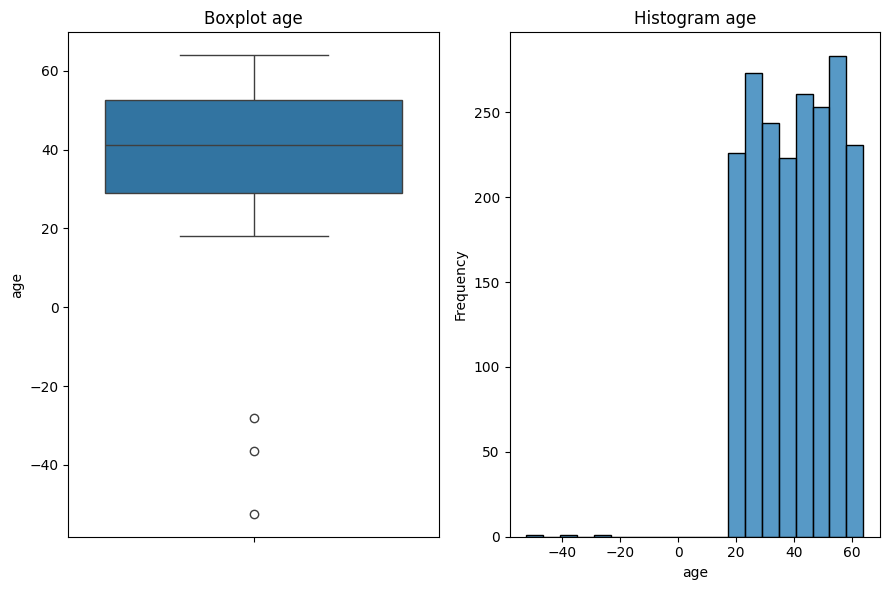

In [9]:
box_hist_plot(df_credit, 'age')

In [10]:
# FILLING NaN AND NEGATIVE AGE VALUES WITH THE MEAN

age_mean = df_credit[df_credit['age'] > 0]['age'].mean()
df_credit['age'] = df_credit['age'].fillna(age_mean)
df_credit.loc[df_credit['age'] < 0, 'age'] = age_mean

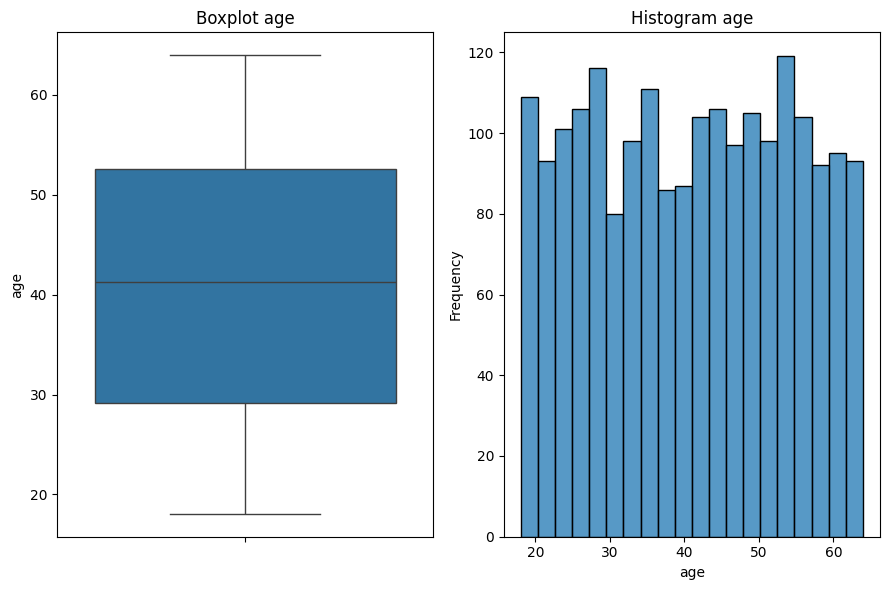

In [11]:
box_hist_plot(df_credit, 'age')

In [12]:
# DEFAULT: 1=IN DEBT; 0=NO DEBT
df_credit['default'].value_counts() # 283 PEOPLE IN DEBT

default
0    1717
1     283
Name: count, dtype: int64

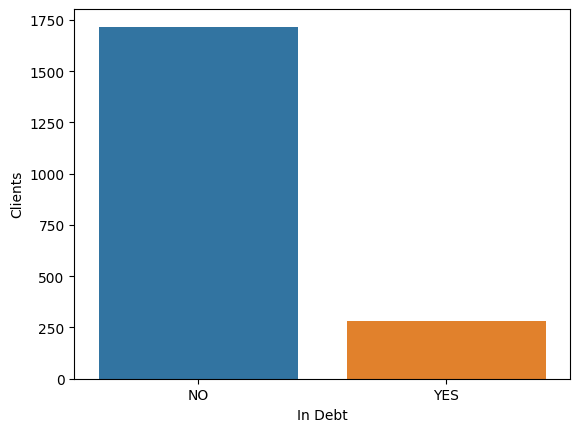

In [13]:
# PROPORÇÃO DÍVIDA X SEM DÍVIDA
ax = sns.countplot(data=df_credit, x = 'default', hue='default', dodge=False)
ax.set(xlabel='In Debt', ylabel='Clients', xticks=range(2), xticklabels=['NO', 'YES'])
ax.legend().set_visible(False)
plt.show()

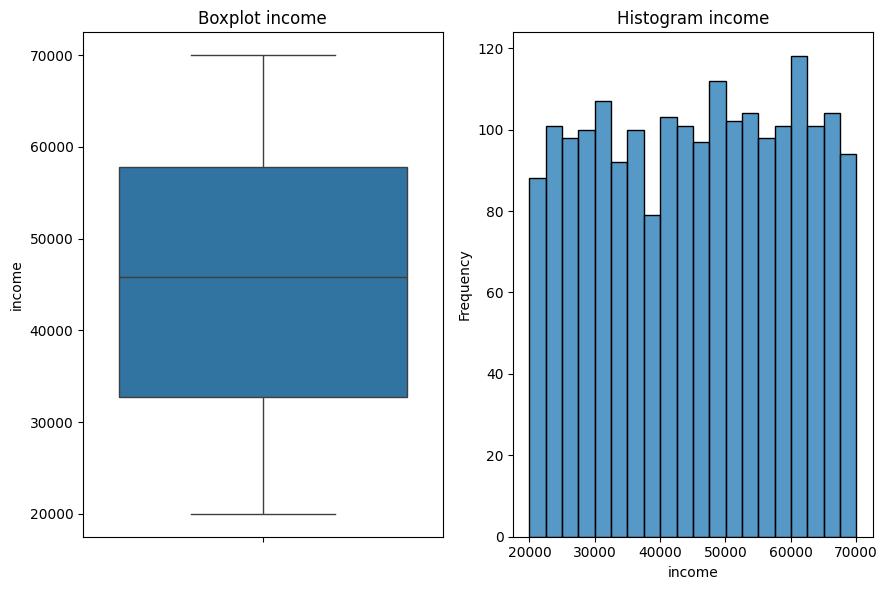

In [14]:
box_hist_plot(df=df_credit, x='income')

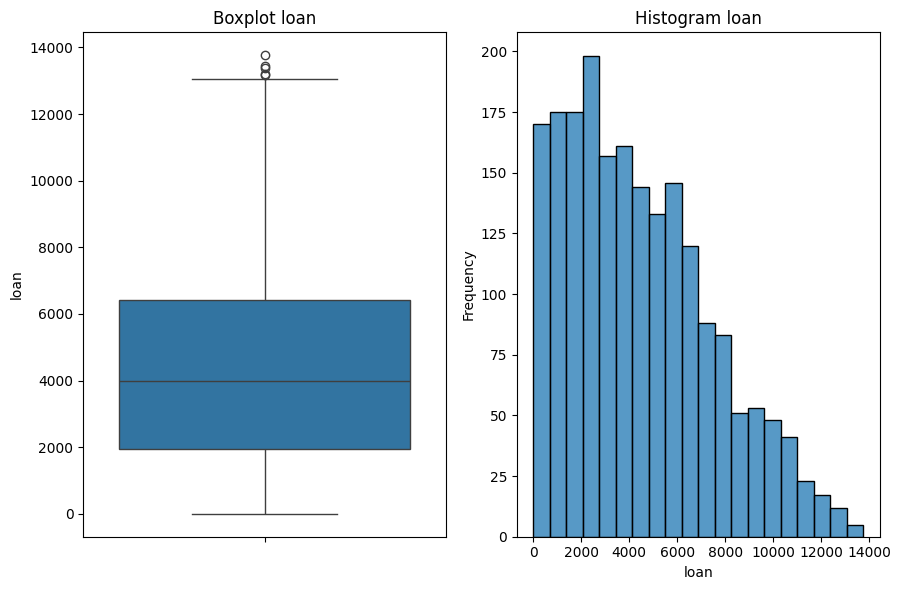

In [15]:
box_hist_plot(df=df_credit, x='loan')

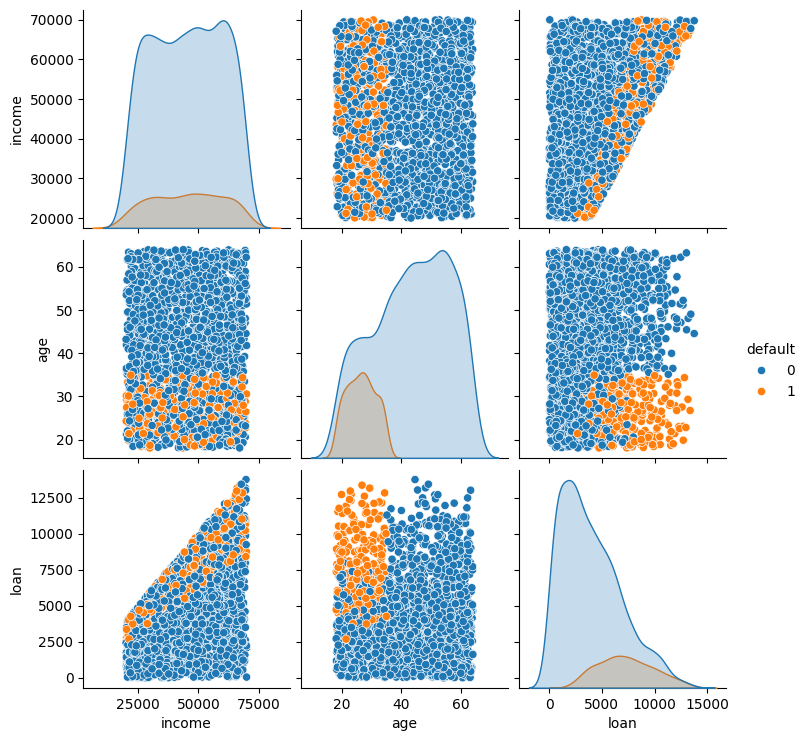

In [16]:
ax = sns.pairplot(data=df_credit.drop(['clientid'], axis=1), hue='default')

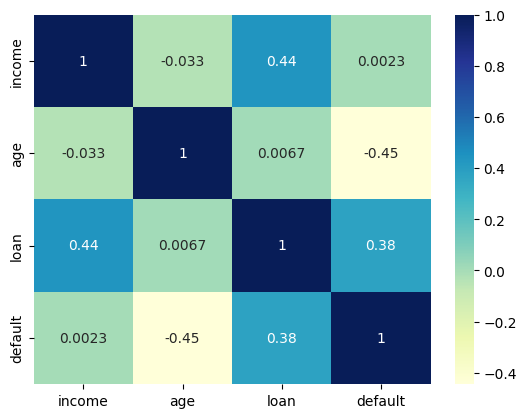

In [17]:
corr = df_credit.drop('clientid', axis=1).corr()
sns.heatmap(corr, cmap='YlGnBu', annot=True)
plt.show()

**From the Correlation Coefficients, we have:**

- INCOME ⇔ LOAN (Moderate at *44%*)
- LOAN ⇔ DEFAULT (Weak at *38%*)
- AGE ⇔ DEFAULT (Moderate Negative at *-45%*)
---

- **Division between predictors and class**

In [19]:
x_credit = df_credit.drop(['clientid', 'default'], axis=1).to_numpy()
y_credit = df_credit['default'].to_numpy()
x_credit[0], y_credit[0]

(array([6.61559251e+04, 5.90170151e+01, 8.10653213e+03]), 0)

- **Scaling the values**

The need for "scaling" is an attempt to make values with very different scales closer to each other. This is to prevent algorithms from assuming that this difference shows that one value has a greater "influence" than another distant value. For example, this could mean that the "Income" attribute is much more important than "Age," which is a problem in machine learning. The goal is to try to normalize/standardize these values so as not to suggest this.

***Standardization***:
More suitable when there are outliers in the dataset.
$$ x = \frac{x_i - \bar{x}}{\sigma} $$
***Normalization***:
$$ x = \frac{x_i - \text{min}(x)}{\text{max}(x) - \text{min}(x)} $$

In [20]:
scaler= StandardScaler()
x_credit = scaler.fit_transform(x_credit)
x_credit[0], y_credit[0]

(array([1.45393393, 1.36538005, 1.20281942]), 0)

---
### CENSUS DATASET

- ***GOAL***: Predict the 'income' feature

In [21]:
df_census = pd.read_csv('data/census.csv')
print(f'Rows: {df_census.shape[0]}; Columns: {df_census.shape[1]}')
df_census.head()

Rows: 32561; Columns: 15


,age,workclass,final-weight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loos,hour-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [22]:
df_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   final-weight    32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loos    32561 non-null  int64 
 12  hour-per-week   32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [23]:
df_census.duplicated().sum()

24

In [24]:
df_census = df_census.drop_duplicates(keep=False)

In [25]:
df_census.describe()

,age,final-weight,education-num,capital-gain,capital-loos,hour-per-week
count,32514.000000,3.251400e+04,32514.000000,32514.000000,32514.000000,32514.000000
mean,38.589039,1.897835e+05,10.082703,1079.206619,87.430030,40.443194
std,13.635528,1.055614e+05,2.570894,7390.514416,403.237687,12.346159
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178285e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783545e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.369830e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [26]:
df_census.describe(include='O')

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,32514,32514,32514,32514,32514,32514,32514,32514,32514
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22651,10487,14964,4132,13181,27775,21760,29136,24677


**Some intriguing points:**

- **capital-gain**: The 3 quartiles are zero.
    - After Analysis: 'Capital Gain' = ZERO represents 91.6% of the data, therefore, the 3 quartiles are zero and the data seems fine.
        - 79.3% of clients with 'Capital Gain' = ZERO has income <=50K and 20.7% has income >50K
        - 38.2% of clients with 'Capital Gain' > ZERO has income <=50K and 61.8% has income >50K
- **capital-loss**: The 3 quartiles are zero.
    - After Analysis: 'Capital Loos' = ZERO represents 95.3% of the data, therefore, the 3 quartiles are zero and the data seems fine.
        - 77.3% of clients with 'Capital Loos' = ZERO has income <=50K and 22.8% has income >50K
        - 49.1% of clients with 'Capital Loos' > ZERO has income <=50K and 50.9% has income >50K
- **hours-per-week**: Very distant range; min=1h/week & max=99h/week. 
    - After Analysis: Despite the high values of hours, the data does not seem to deviate significantly from normality.

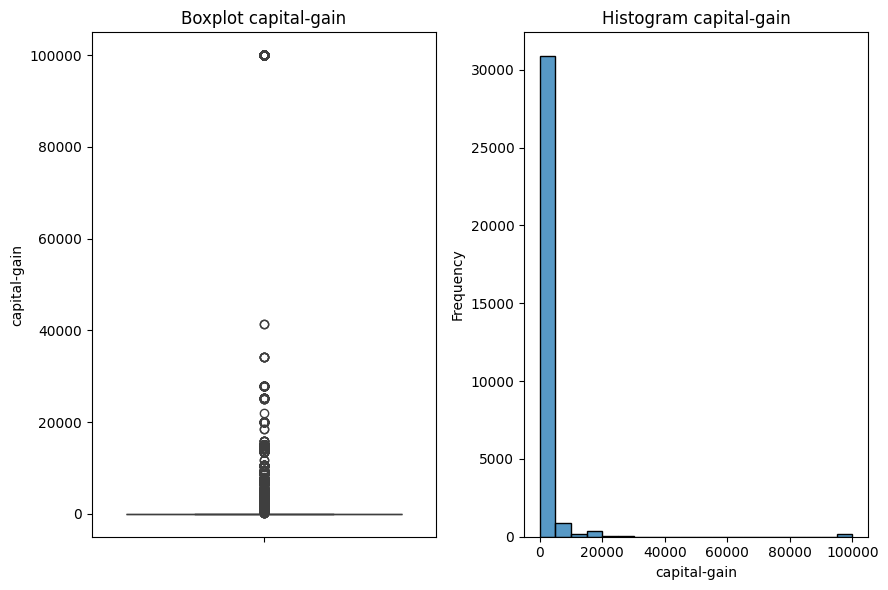

In [27]:
box_hist_plot(df=df_census, x='capital-gain')

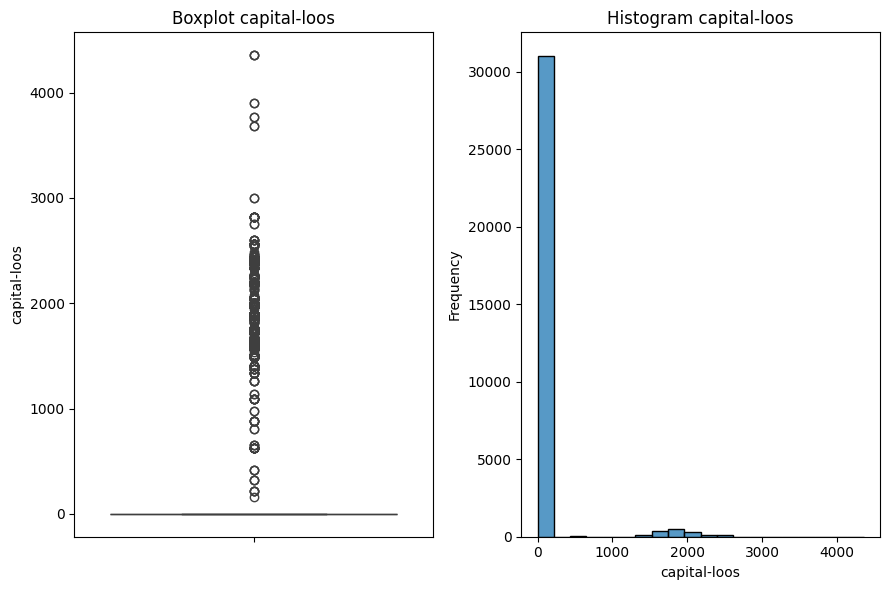

In [28]:
box_hist_plot(df=df_census, x='capital-loos')

In [29]:
cg0_and_bigIncome = len(df_census[(df_census['capital-gain'] == 0) & (df_census['income'] == ' >50K')])
cg0_and_smallIncome = len(df_census[(df_census['capital-gain'] == 0) & (df_census['income'] == ' <=50K')])

cgnot0_and_bigIncome = len(df_census[(df_census['capital-gain'] > 0) & (df_census['income'] == ' >50K')])
cgnot0_and_smallIncome = len(df_census[(df_census['capital-gain'] > 0) & (df_census['income'] == ' <=50K')])

cl0_and_bigIncome = len(df_census[(df_census['capital-loos'] == 0) & (df_census['income'] == ' >50K')])
cl0_and_smallIncome = len(df_census[(df_census['capital-loos'] == 0) & (df_census['income'] == ' <=50K')])

clnot0_and_bigIncome = len(df_census[(df_census['capital-loos'] > 0) & (df_census['income'] == ' >50K')])
clnot0_and_smallIncome = len(df_census[(df_census['capital-loos'] > 0) & (df_census['income'] == ' <=50K')])

print(f'(capital-gain = 0 and income  >50K) count: {cg0_and_bigIncome}')
print(f'(capital-gain = 0 and income <=50K) count: {cg0_and_smallIncome}')

print(f'(capital-gain > 0 and income  >50K) count: {cgnot0_and_bigIncome}')
print(f'(capital-gain > 0 and income <=50K) count: {cgnot0_and_smallIncome}')

print(f'(capital-loos = 0 and income  >50K) count: {cl0_and_bigIncome}')
print(f'(capital-loos = 0 and income <=50K) count: {cl0_and_smallIncome}')

print(f'(capital-loos > 0 and income  >50K) count: {clnot0_and_bigIncome}')
print(f'(capital-loos > 0 and income <=50K) count: {clnot0_and_smallIncome}')


(capital-gain = 0 and income  >50K) count: 6160
(capital-gain = 0 and income <=50K) count: 23642
(capital-gain > 0 and income  >50K) count: 1677
(capital-gain > 0 and income <=50K) count: 1035
(capital-loos = 0 and income  >50K) count: 7064
(capital-loos = 0 and income <=50K) count: 23931
(capital-loos > 0 and income  >50K) count: 773
(capital-loos > 0 and income <=50K) count: 746


**FROM THE ABOVE CODE WE STATE THE FOLLOWING TABLE:**


|   | <=50K | >50K |
|:------------- |:---------------:| -------------:|
| Capital Gain = 0 | 23642 (79.3%)| 6160 (20.7%)  |
| Capital Gain > 0 | 1035 (38.2%) | 1677 (61.8%)  |
| Capital Loos = 0 | 23931 (77.2%)| 7064 (22.8%)  |
| Capital Loos > 0 | 746 (49.1%)  | 773 (50.9%)   |

**MEANING:**
- 'Capital Gain' = ZERO represents 91.6% of the data.
    - 79.3% of clients with 'Capital Gain' = ZERO has income <=50K and 20.7% has income >50K
    - 38.2% of clients with 'Capital Gain' > ZERO has income <=50K and 61.8% has income >
- 'Capital Loos' = ZERO represents 95.3% of the data.
    - 77.3% of clients with 'Capital Loos' = ZERO has income <=50K and 22.8% has income >50K
    - 49.1% of clients with 'Capital Loos' > ZERO has income <=50K and 50.9% has income >50K

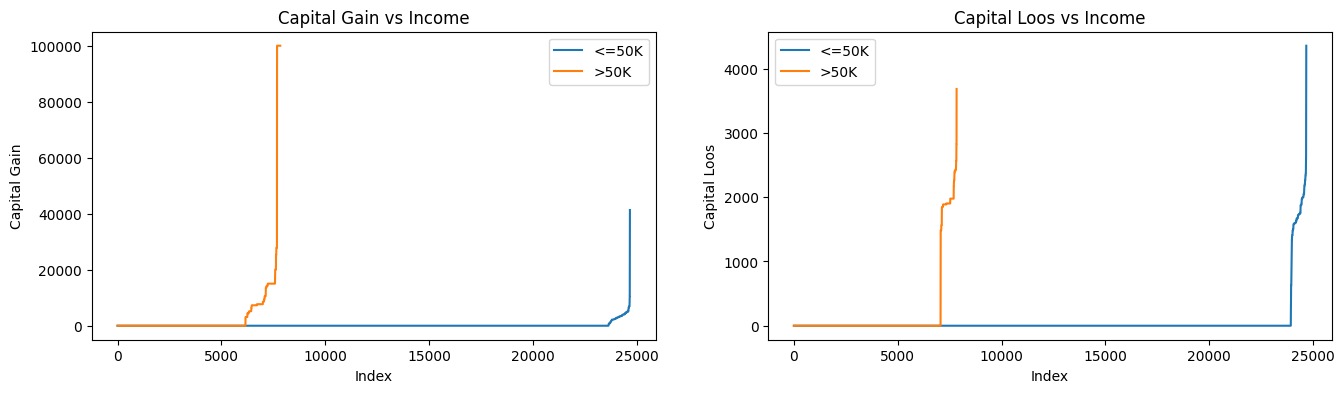

In [30]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
g=df_census[df_census['income'] ==' <=50K']['capital-gain'].sort_values().reset_index(drop=True).plot()
g=df_census[df_census['income'] ==' >50K']['capital-gain'].sort_values().reset_index(drop=True).plot(ax=g)
g.set_title('Capital Gain vs Income')
g.set_xlabel('Index')
g.set_ylabel('Capital Gain')
g = g.legend(['<=50K', '>50K'])

plt.subplot(1,2,2)
g = df_census[df_census['income'] == ' <=50K']['capital-loos'].sort_values().reset_index(drop=True).plot()
g = df_census[df_census['income'] == ' >50K']['capital-loos'].sort_values().reset_index(drop=True).plot(ax=g)
g.set_title('Capital Loos vs Income')
g.set_xlabel('Index')
g.set_ylabel('Capital Loos')
g = g.legend(['<=50K', '>50K'])

---
- **CHECKING 'hour-per-week' FEATURE**

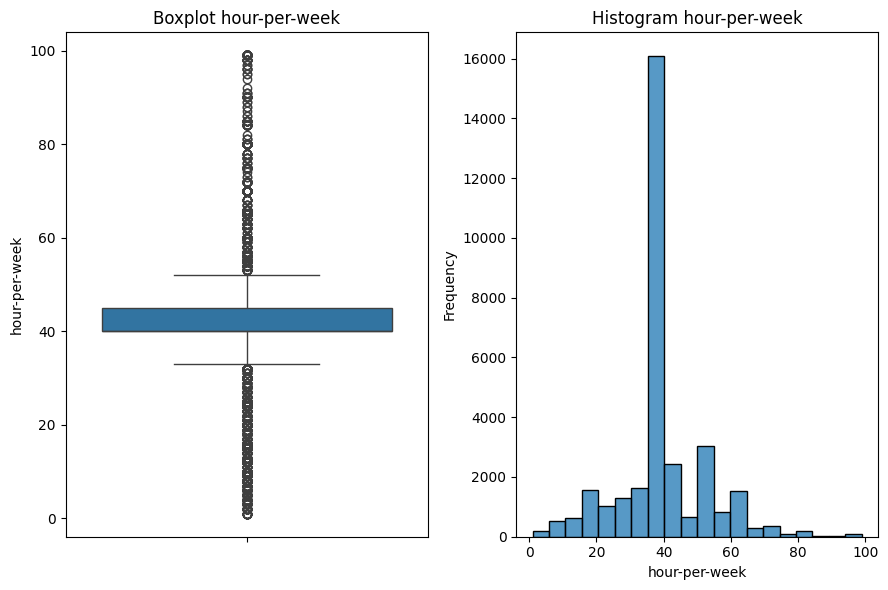

In [31]:
box_hist_plot(df=df_census, x='hour-per-week')

In [32]:
df_census.loc[df_census['hour-per-week'] > 45, ['hour-per-week']].value_counts().sort_index()

hour-per-week
46                 82
47                 49
48                515
49                 29
50               2815
51                 13
52                138
53                 25
54                 41
55                692
56                 97
57                 17
58                 28
59                  5
60               1475
61                  2
62                 18
63                 10
64                 14
65                244
66                 17
67                  4
68                 12
70                291
72                 71
73                  2
74                  1
75                 66
76                  3
77                  6
78                  8
80                133
81                  3
82                  1
84                 45
85                 13
86                  2
87                  1
88                  2
89                  2
90                 29
91                  3
92                  1
94                  1
95                

---
- **QUICK VIEW AT 'income' CLASS DISTRIBUTION**

In [33]:
df_census['income'].value_counts()

income
 <=50K    24677
 >50K      7837
Name: count, dtype: int64

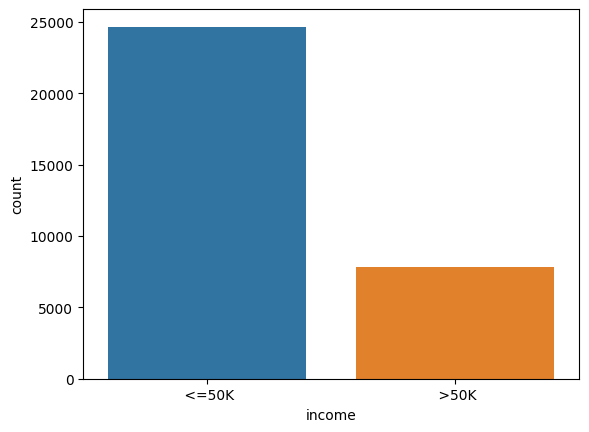

In [34]:
ax = sns.countplot(data=df_census, x='income', hue='income', dodge=False)
plt.show()

---
- **CHECKING OTHER FEATURES**

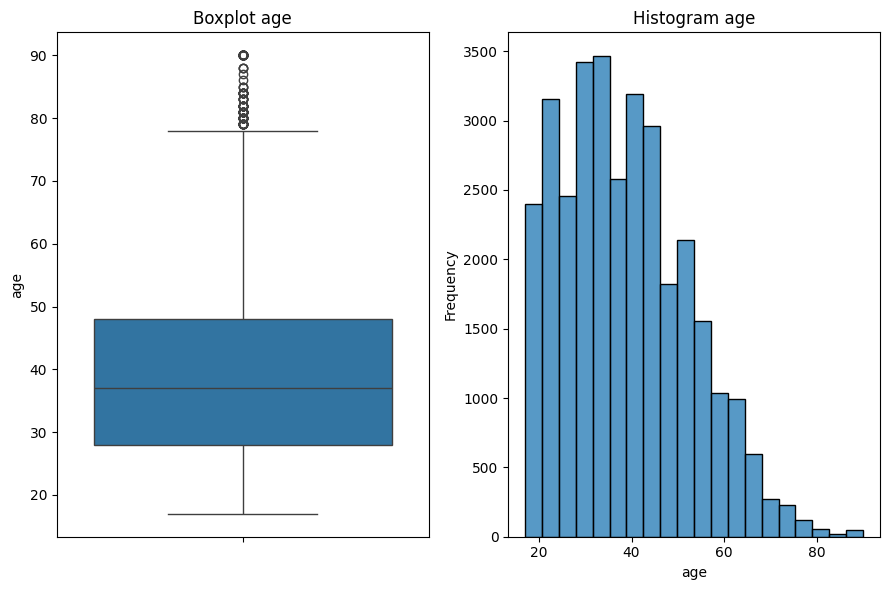

In [35]:
box_hist_plot(df=df_census, x='age')

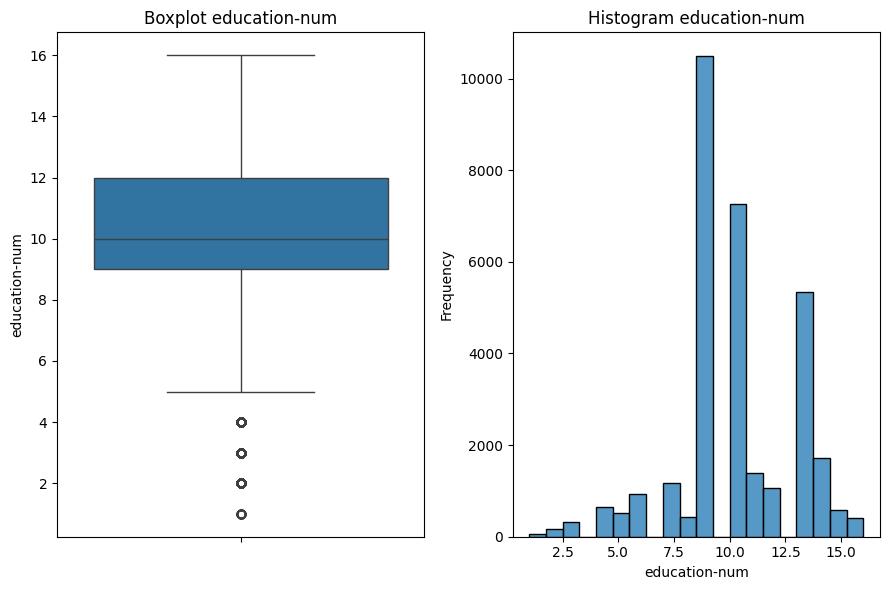

In [36]:
box_hist_plot(df_census, x='education-num')

- **CATEGORIC VARIABLES ENCODING**

In [37]:
df_census_encoded = df_census.copy()
df_census_encoded.head()

,age,workclass,final-weight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loos,hour-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [38]:
df_census_encoded = df_census_encoded.join(pd.get_dummies(df_census_encoded['workclass'], prefix='work', dtype='int64')).drop('workclass', axis=1)
df_census_encoded = df_census_encoded.join(pd.get_dummies(df_census_encoded['marital-status'], prefix='marital-status', dtype='int64')).drop('marital-status', axis=1)
df_census_encoded = df_census_encoded.join(pd.get_dummies(df_census_encoded['occupation'], prefix='occupation', dtype='int64')).drop('occupation', axis=1)
df_census_encoded = df_census_encoded.join(pd.get_dummies(df_census_encoded['relationship'], prefix='relationship', dtype='int64')).drop('relationship', axis=1)
df_census_encoded = df_census_encoded.join(pd.get_dummies(df_census_encoded['race'], prefix='race', dtype='int64')).drop('race', axis=1)
df_census_encoded = df_census_encoded.join(pd.get_dummies(df_census_encoded['sex'], prefix='sex', dtype='int64')).drop('sex', axis=1)
df_census_encoded = df_census_encoded.join(pd.get_dummies(df_census_encoded['native-country'], prefix='country', dtype='int64')).drop('native-country', axis=1)

In [39]:
df_census_encoded

,age,final-weight,education,education-num,capital-gain,capital-loos,hour-per-week,income,work_ ?,work_ Federal-gov,...,country_ Portugal,country_ Puerto-Rico,country_ Scotland,country_ South,country_ Taiwan,country_ Thailand,country_ Trinadad&Tobago,country_ United-States,country_ Vietnam,country_ Yugoslavia
0,39,77516,Bachelors,13,2174,0,40,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,Bachelors,13,0,0,13,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,HS-grad,9,0,0,40,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,11th,7,0,0,40,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,Bachelors,13,0,0,40,<=50K,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,Assoc-acdm,12,0,0,38,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,40,154374,HS-grad,9,0,0,40,>50K,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,58,151910,HS-grad,9,0,0,40,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,22,201490,HS-grad,9,0,0,20,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0


In [40]:
education_order = [' Preschool', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th',
                ' 10th', ' 11th', ' 12th', ' HS-grad', ' Some-college', ' Assoc-voc',
                ' Assoc-acdm', ' Bachelors', ' Masters', ' Prof-school', ' Doctorate']

encoder = OrdinalEncoder(categories=[education_order])

df_census_encoded['education'] = encoder.fit_transform(df_census_encoded[['education']])

In [41]:
df_census_encoded.head()

,age,final-weight,education,education-num,capital-gain,capital-loos,hour-per-week,income,work_ ?,work_ Federal-gov,...,country_ Portugal,country_ Puerto-Rico,country_ Scotland,country_ South,country_ Taiwan,country_ Thailand,country_ Trinadad&Tobago,country_ United-States,country_ Vietnam,country_ Yugoslavia
0,39,77516,12.0,13,2174,0,40,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,12.0,13,0,0,13,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,8.0,9,0,0,40,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,6.0,7,0,0,40,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,12.0,13,0,0,40,<=50K,0,0,...,0,0,0,0,0,0,0,0,0,0


- **SCALE**

In [42]:
x_census = df_census_encoded.drop('income', axis=1).to_numpy()
y_census = df_census_encoded['income']
x_census[0], y_census[0]

(array([3.9000e+01, 7.7516e+04, 1.2000e+01, 1.3000e+01, 2.1740e+03,
        0.0000e+00, 4.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

In [43]:
scaler = StandardScaler()
x_census = scaler.fit_transform(x_census)
x_census[0]

array([ 0.03013948, -1.063545  ,  1.13475762,  1.13475762,  0.14813721,
       -0.21682342, -0.03589785, -0.24463738, -0.17442487, -0.26229975,
       -0.01467441, -1.51544149, -0.18853028, -0.29103938,  4.90400924,
       -0.02075498, -0.39763325, -0.02660617, -0.92339026, -0.11412024,
        1.43261458, -0.18041909, -0.1774903 , -0.24513126,  2.76289042,
       -0.01663973, -0.37927858, -0.37795119, -0.17721356, -0.20957617,
       -0.25587858, -0.33535728, -0.06716121, -0.38155633, -0.14271361,
       -0.35560526, -0.17121603, -0.22727611, -0.82570432,  1.71079268,
       -0.17638102, -0.42931142, -0.34419857, -0.22509755, -0.09827251,
       -0.18150672, -0.32579765, -0.09167838,  0.41306302, -0.7030004 ,
        0.7030004 , -0.13488641, -0.02418068, -0.06111771, -0.04808359,
       -0.04263686, -0.05413299, -0.04644958, -0.0293583 , -0.05719089,
       -0.05268512, -0.02987842, -0.0650492 , -0.02987842, -0.04335483,
       -0.03681164, -0.00554589, -0.01999969, -0.02480924, -0.01

---
- **SPLIT 'CREDIT' DATASET AND 'CENSUS' DATASET WITH A TRAINING GROUP AND TEST GROUP** 

In [44]:
x_credit_training, x_credit_test, y_credit_training, y_credit_test = train_test_split(x_credit, y_credit, test_size=.25, random_state = 0)
x_census_training, x_census_test, y_census_training, y_census_test = train_test_split(x_census, y_census, test_size=.25, random_state = 0)

In [45]:
x_credit_training.shape, x_credit_test.shape, y_credit_training.shape, y_credit_test.shape

((1500, 3), (500, 3), (1500,), (500,))

In [46]:
x_census_training.shape, x_census_test.shape, y_census_training.shape, y_census_test.shape

((24385, 93), (8129, 93), (24385,), (8129,))

---
- **SAVE PRE-PROCESSED DATA!**

In [47]:
with open('data/census.pkl', 'wb') as file:
    pickle.dump([x_census_training, y_census_training, x_census_test, y_census_test], file)

In [48]:
with open('data/credit.pkl', 'wb') as file:
    pickle.dump([x_credit_training, y_credit_training, x_credit_test, y_credit_test], file)